# Water Flood Segmentation 

### Import libraries

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


In [5]:
# Reproducability
def set_seed(seed=125):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(125)


In [6]:
BATCH_SIZE = 8
IMG_SIZE = 128

### Data visualization

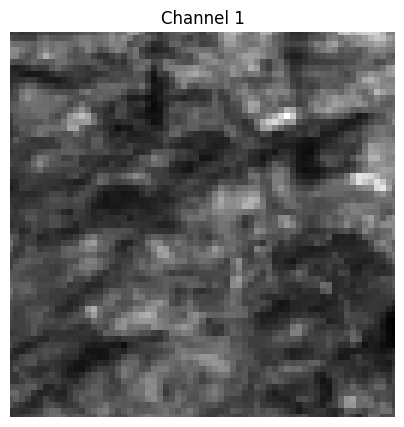

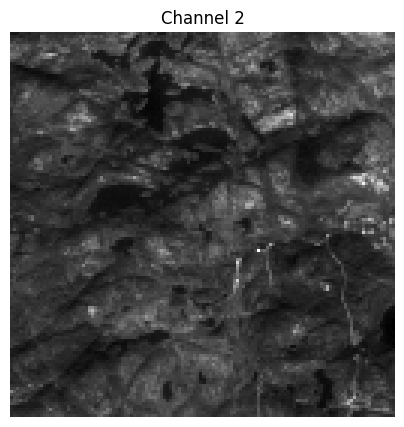

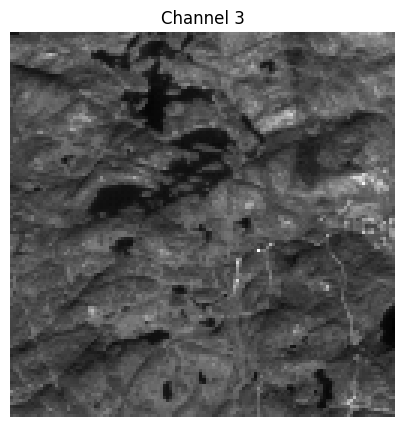

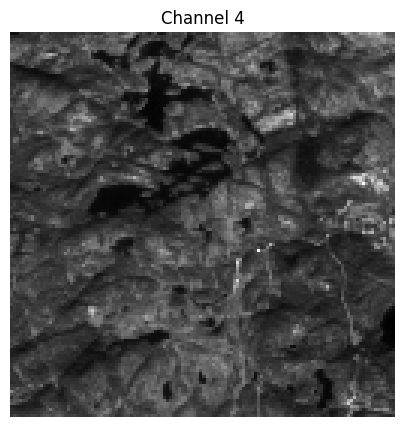

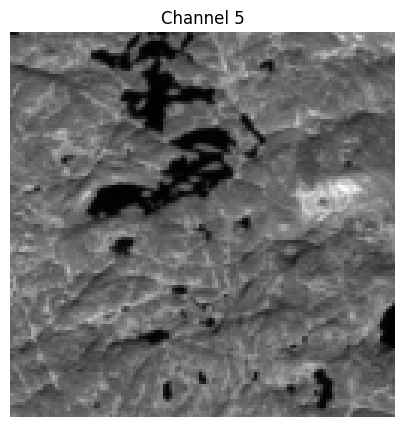

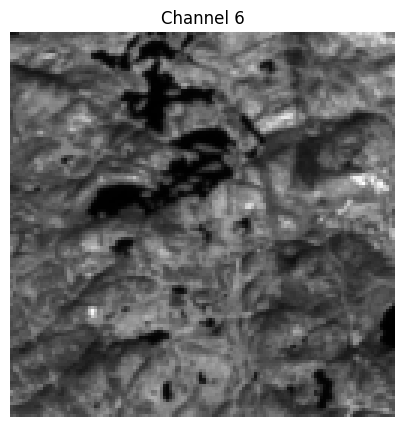

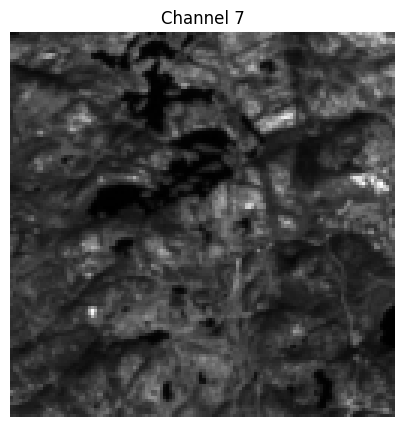

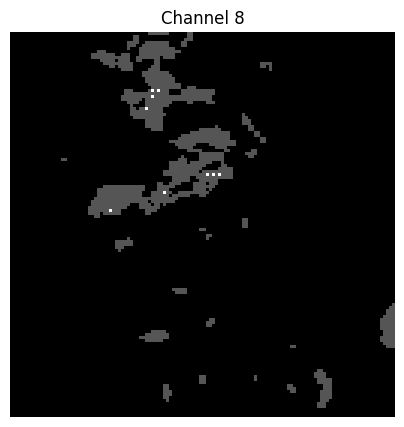

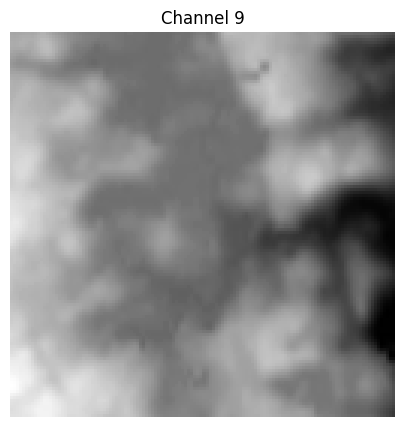

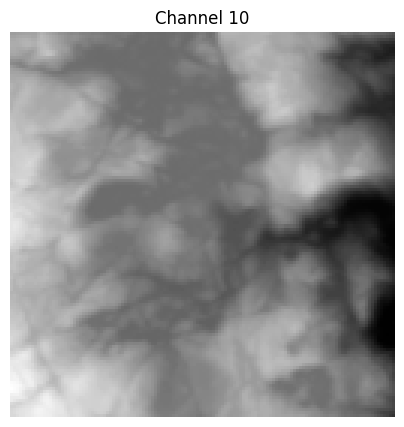

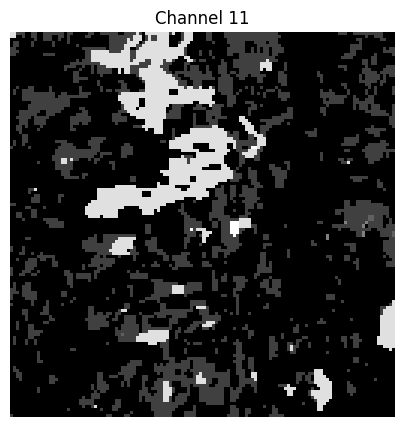

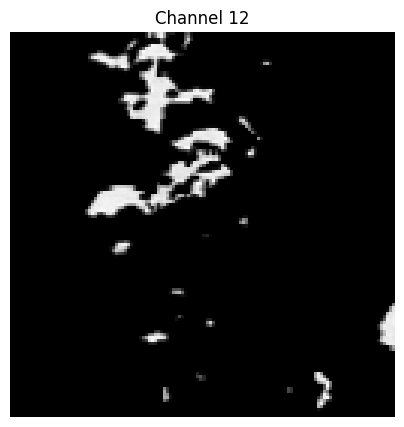

In [7]:
# Read the TIFF file
tif_path = 'data/images/0.tif'  
tif_image = tiff.imread(tif_path)

# Check the number of channels
num_channels = tif_image.shape[2]

# Plot each channel
for i in range(num_channels):
    plt.figure(figsize=(5, 5))
    plt.imshow(tif_image[:,:,i], cmap='gray')
    plt.title(f'Channel {i + 1}')
    plt.axis('off')
    plt.show()

In [8]:
tif_image.shape

(128, 128, 12)

In [9]:
#get the rgb channels
rgb_image = tif_image[:,:,1:4]
rgb_image = rgb_image[:,:,::-1]

In [10]:
# Normalize the image data to the range 0-1
rgb_image = rgb_image.astype(np.float32)
rgb_image -= rgb_image.min()  
rgb_image /= rgb_image.max()  
rgb_image *= 255.0

# Convert to uint8 type
rgb_image = rgb_image.astype(np.uint8)

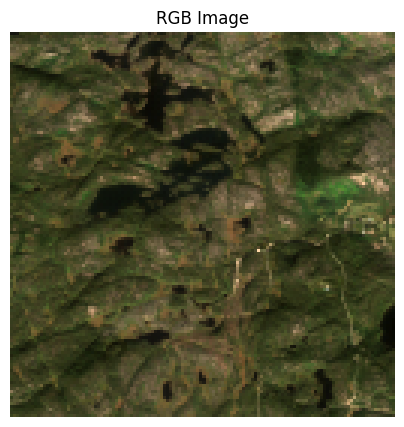

In [11]:
# Plot the RGB image
plt.figure(figsize=(5, 5))
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')
plt.show()

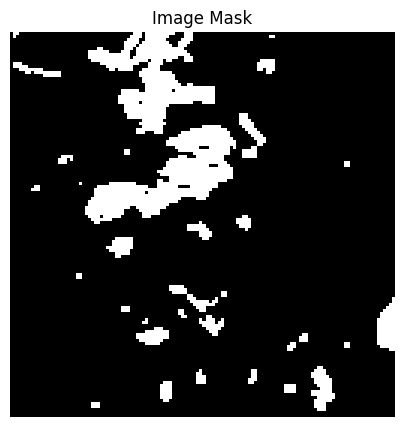

In [12]:
# Read the image mask
png_path = 'data/labels/0.png'  
png_image = Image.open(png_path)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(png_image, cmap='gray')
plt.title('Image Mask')
plt.axis('off')
plt.show()

### Data preprocessing

In [13]:
# Paths
img_dir = "data/images"
label_dir = "data/labels"

In [14]:
# Get exact image base names 
image_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.tif')}
label_files = os.listdir(label_dir)

# Remove labels that don't match an image filename 
for label_file in label_files:
    base_name = os.path.splitext(label_file)[0]  # No splitting by underscore now
    if base_name not in image_files:
        os.remove(os.path.join(label_dir, label_file))


In [15]:
num_images = len([f for f in os.listdir(img_dir) if f.endswith('.tif')])
num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.png')])

print(f"Number of images in '{img_dir}': {num_images}")
print(f"Number of labels in '{label_dir}': {num_labels}")

Number of images in 'data/images': 306
Number of labels in 'data/labels': 306


In [16]:
# Function to compute per-channel max values
def get_max_of_channels(image_dir):
    image_maxs = np.full(12, -np.inf)
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path)
            image_maxs = np.maximum(image_maxs, image.max(axis=(0,1)))
    return image_maxs

# Function to compute per-channel min values
def get_min_of_channels(image_dir):
    image_mins = np.full(12, np.inf)
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path)
            image_mins = np.minimum(image_mins, image.min(axis=(0,1)))
    return image_mins

image_maxs = get_max_of_channels(img_dir)
image_mins = get_min_of_channels(img_dir)

print(image_maxs)
print(image_mins)

[ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]
[-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.580e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]


In [17]:
# Load and preprocess images
def load_image(image_path, label_path):
    image = tiff.imread(image_path).astype(np.float32)
    label = np.array(Image.open(label_path)).astype(np.float32)
    if label.max() > 1:
        label /= 255.0  # Normalize label if in range [0,255]
    return image, label

#normalize images
def preprocess_image(image):
    for i in range(image.shape[2]):
        min_val, max_val = image_mins[i], image_maxs[i]
        if max_val > min_val:  
            image[:, :, i] = (image[:, :, i] - min_val) / (max_val - min_val)
    return image.astype(np.float32)

def load_data(image_dir, label_dir):
    images, labels = [], []
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            label_path = os.path.join(label_dir, image_name.replace('.tif', '.png'))
            if os.path.exists(label_path):
                image, label = load_image(image_path, label_path)
                images.append(preprocess_image(image))
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_data(img_dir, label_dir)

In [18]:
print("After Normalization:")
print("Min pixel value:", images.min(), ", Max pixel value:", images.max())

After Normalization:
Min pixel value: 0.0 , Max pixel value: 1.0


In [19]:
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=125
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=125
)

# Check the shapes
print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Validation set: {val_images.shape}, {val_labels.shape}")
print(f"Testing set: {test_images.shape}, {test_labels.shape}")

Training set: (244, 128, 128, 12), (244, 128, 128)
Validation set: (31, 128, 128, 12), (31, 128, 128)
Testing set: (31, 128, 128, 12), (31, 128, 128)


In [20]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Model Architecture & Training

In [18]:
from tensorflow.keras.layers import Input, Conv2D, Add, MaxPooling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def conv_block(inputs, num_filters):
    # Shortcut path
    shortcut = inputs
    
    # Adjust shortcut dimensions if needed
    shortcut = Conv2D(num_filters, (1, 1), padding='same', kernel_regularizer=l2(0.001))(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    # Residual path
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, (3, 3), activation=None, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    # Add shortcut to the residual path
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    
    return x
def encoder_block(inputs, drop_out, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    p = SpatialDropout2D(drop_out)(p)
    
    return x, p
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding='same')(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x ,num_filters)
    
    return x
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    s0, p0 = encoder_block(inputs, 0.1, 12)
    s1, p1 = encoder_block(p0, 0.1, 32)
    s2, p2 = encoder_block(p1, 0.1, 64)
    s3, p3 = encoder_block(p2, 0.2, 128)
    s4, p4 = encoder_block(p3, 0.2, 128)
    
    # Bridge
    b1 = conv_block(p4, 256)
    
    # Decoder
    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)
    d5 = decoder_block(d4, s0, 32)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model
# Instantiate the model
input_shape = (128, 128, 12)  
model = unet_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      1,308 │ input_layer[0][0] │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         48 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      1,308 │ activation[0][0]  │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        156 │ input_layer[0][0] │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         48 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         48 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 12)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      3,488 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │        416 │ spatial_dropout2

 Total params: 2,910,501 (11.10 MB)

 Trainable params: 2,904,477 (11.08 MB)

 Non-trainable params: 6,024 (23.53 KB)

In [19]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  

    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Apply threshold

    y_true = tf.reshape(y_true, [-1])  # Flatten
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=[iou_metric, dice_coefficient])

In [21]:
# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   
    patience=7,          
    restore_best_weights=True 
)

In [22]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'segmodel.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [23]:
# ReduceLROnPlateau
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,     
    patience=3,          
    min_lr=1e-6, 
)

In [24]:
# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=50, 
    callbacks=[early_stopping, reduce_lr_on_plateau, checkpoint]
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 445ms/step - dice_coefficient: 0.5175 - iou_metric: 0.3721 - loss: 2.8846 - val_dice_coefficient: 0.4122 - val_iou_metric: 0.2651 - val_loss: 1.6568 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 448ms/step - dice_coefficient: 0.7211 - iou_metric: 0.5691 - loss: 1.2228 - val_dice_coefficient: 2.3594e-11 - val_iou_metric: 2.3594e-11 - val_loss: 1.1981 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - dice_coefficient: 0.7655 - iou_metric: 0.6345 - loss: 0.7904 - val_dice_coefficient: 2.3594e-11 - val_iou_metric: 2.3594e-11 - val_loss: 1.0488 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 462ms/step - dice_coefficient: 0.7647 - iou_metric: 0.6282 - loss: 0.6326 - val_dice_coefficient: 2.3594e-11 - val_iou_metric: 2.3594e-11 - val_loss: 0.9681 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - dice_coefficient: 0.7932 - iou_metric: 0.6659 - loss: 0.5348 

In [25]:
# function to plot loss

def plot_loss( loss, val_loss, epochs):
    
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

<Figure size 640x480 with 0 Axes>

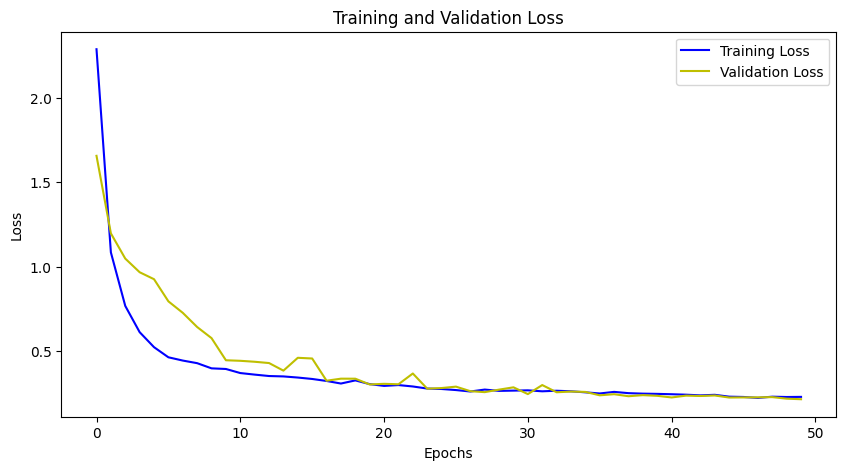

In [26]:
model_history = history.history

loss = model_history['loss']

val_loss = model_history['val_loss']

epochs = history.epoch

plot_loss(loss, val_loss, epochs)

### model evaluation

In [27]:
# Evaluate model
val_loss, val_iou_metric, val_dice_coefficient = model.evaluate(val_dataset)
print(f"Validation IOU: {val_iou_metric:.4f}")
print(f"Validation Dice Coefficient: {val_dice_coefficient:.4f}")
print(f"Validation loss: {val_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - dice_coefficient: 0.8817 - iou_metric: 0.7910 - loss: 0.2297
Validation IOU: 0.8087
Validation Dice Coefficient: 0.8930
Validation loss: 0.2168


In [28]:
# Save the Model
model.save("water_segmentation_model.h5")

In [29]:
model= load_model("water_segmentation_model.h5", compile= False)

In [31]:
#evaluate on test set
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Predict on the test set
y_pred = model.predict(test_dataset)
y_true= test_labels

test_iou= iou_metric(y_true, y_pred)
print(f"IoU: {test_iou:.4f}")

test_dice= dice_coefficient(y_true, y_pred)
print(f"Dice: {test_dice:.4f}")

# Calculate Precision, Recall, and F1-Score 
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)  

# Flatten arrays
y_true_flat = y_true.flatten()
y_pred_flat = y_pred_binary.flatten()

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print(f"Precision: {precision :.4f}, Recall: {recall :.4f}, F1-Score: {f1 :.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
IoU: 0.7298
Dice: 0.8438
Precision: 0.9314, Recall: 0.7712, F1-Score: 0.8438


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


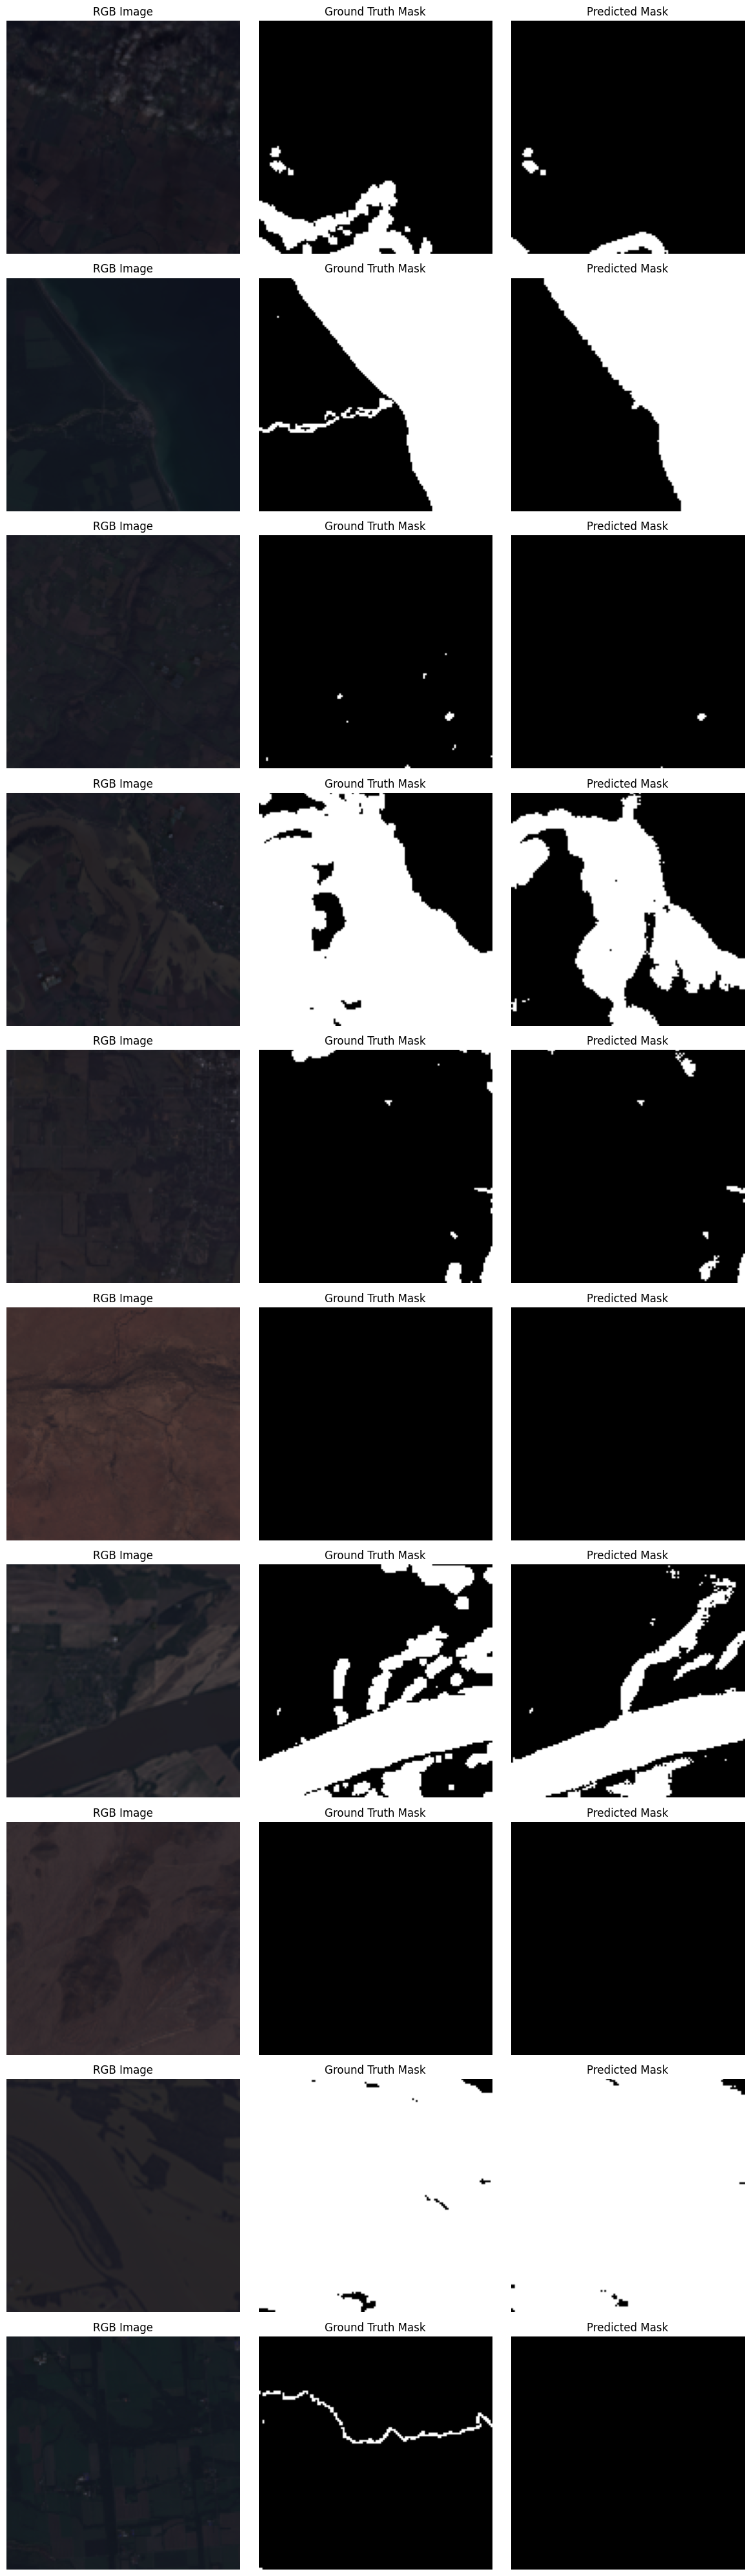

In [ ]:
import matplotlib.pyplot as plt

model= load_model("water_segmentation_model.h5", compile= False)

num_samples = 10
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)
sample_images = test_images[sample_indices]  # RGB images
sample_masks = test_labels[sample_indices]   # Ground truth masks
predicted_masks = model.predict(sample_images)  # Predicted masks

# Convert predicted masks to binary using a threshold
threshold = 0.5
predicted_masks_binary = (predicted_masks > threshold).astype(int)

# Plot results
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))

for i in range(num_samples):
    axes[i, 0].imshow(sample_images[i][:, :,[3, 2, 1]])  # RGB image
    axes[i, 0].set_title("RGB Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sample_masks[i].squeeze(), cmap="gray")  # Ground truth mask
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predicted_masks_binary[i].squeeze(), cmap="gray")  # Predicted mask
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
